In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_gedmd_torch_gpu import KoopmanNNTorch as KoopmanNNTorch_g
from solver_gedmd_torch_gpu import  KoopmanSolverTorch as KoopmanSolverTorch_g
print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
# device= 'cpu'
device= 'cuda'

2.3.1 True
11.8
NVIDIA GeForce RTX 3070 Ti


In [2]:
## Define the potential function V(x, y) and plot the potential landscape
def potential(x, y):
    return (
        3 * np.exp(-x**2 - (y - 1/3)**2)
        - 3 * np.exp(-x**2 - (y - 5/3)**2)
        - 5 * np.exp(-(x - 1)**2 - y**2)
        - 5 * np.exp(-(x + 1)**2 - y**2)
        + 0.2 * x**4
        + 0.2 * (y - 1/3)**4
    )

# Define the gradient of the potential function
def gradient(x, y):
    dVdx = (
        -6 * x * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * x * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * (x - 1) * np.exp(-(x - 1)**2 - y**2)
        + 10 * (x + 1) * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * x**3
    )
    dVdy = (
        -6 * (y - 1/3) * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * (y - 5/3) * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * y * np.exp(-(x - 1)**2 - y**2)
        + 10 * y * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * (y - 1/3)**3
    )
    return dVdx, dVdy

## Generate m^2 trajectories in the landscape
# Set the parameters for the SDE
#h = 1e-3  # Integration step size
h = 1e-3  # Integration step size
#h = 1e-5  # Integration step size
n_steps = 100  # Number of integration steps between each evaluation
n_eval = 10  # Number of evaluations
lag_time = h * n_steps  # Lag time

# Set the number of points to select in each dimension
m = 12

# Set the diffusion coefficient
sigma = 1.09
print ('Lag time: ', lag_time)

Lag time:  0.1


In [3]:
# Generate linspace for x and y coordinates
x_values = np.linspace(-2, 2, m)
y_values = np.linspace(-1, 2, m)

# Create a meshgrid from these linspace arrays
xx, yy = np.meshgrid(x_values, y_values)

# Flatten the meshgrid matrices to get the coordinate pairs
x0_values = xx.flatten()
y0_values = yy.flatten()

# Initialize the data_matrix
data_matrix = np.zeros((m**2, n_eval+1, 2))

# Generate trajectories for each selected point
for i in tqdm (range(m**2)):
    x = x0_values[i]
    y = y0_values[i]
    
    for j in range(n_eval+1):
        data_matrix[i, j, 0] = x
        data_matrix[i, j, 1] = y
        
        for k in range(n_steps):
            dVdx, dVdy = gradient(x, y)
            x += -dVdx * h + sigma * np.sqrt(h) * np.random.normal()
            y += -dVdy * h + sigma * np.sqrt(h) * np.random.normal()

# Create a grid of points
x_plot = np.linspace(-2, 2, 100)
y_plot = np.linspace(-1, 2, 100)
X, Y = np.meshgrid(x_plot, y_plot)

100%|██████████| 144/144 [00:02<00:00, 67.86it/s]


In [4]:
# ## Save the data to local folder
# # Create a folder to store the data (if it doesn't exist)
# folder_path = "data"
# os.makedirs(folder_path, exist_ok=True)

# # Save the data_matrix to a file
# file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
# np.save(file_path, data_matrix)

In [5]:
# ## load the data from local folder
# import os
# # Load the data_matrix from the file
# folder_path = "data"
# file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
# data_matrix = np.load(file_path)
# data_matrix.shape

In [6]:
!nvidia-smi

Tue Dec 10 16:17:38 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   50C    P8             18W /  290W |    4785MiB /   8192MiB |     20%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

Shape of data_X: (144, 10, 2)
Shape of data_Y: (144, 10, 2)
Shape of X: (1440, 2)
Shape of Y: (1440, 2)
(1007, 2)


In [8]:


checkpoint_file= 'well2d_example_ckpt004.torch'

basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[10], n_psi_train=7).to(device)  # basis number would be 20


solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn001.torch', 
                            a_b_file= 'a_b_example_3ple_well.jbl', 
                        generator_batch_size= 2, fnn_batch_size= 32, delta_t= lag_time)

solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=16,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
#kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver.get_Psi_X()
Psi_Y = solver.get_Psi_Y()
Koopman_matrix_K = solver.K

outputs = {
    'efuns': efuns,
    'evalues': evalues,
#    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
    'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    }



Epoch: 1 	Training Loss: 0.755530 val loss: 0.812088
saving, val loss enhanced: 0.812087604411237 10000
Epoch: 2 	Training Loss: 0.748143 val loss: 0.802822
saving, val loss enhanced: 0.8028222572053219 0.812087604411237
Epoch: 3 	Training Loss: 0.743124 val loss: 0.797620
saving, val loss enhanced: 0.7976199797385618 0.8028222572053219
Epoch: 4 	Training Loss: 0.732554 val loss: 0.784091
saving, val loss enhanced: 0.7840909838344317 0.7976199797385618
Epoch: 5 	Training Loss: 0.723739 val loss: 0.773784
saving, val loss enhanced: 0.7737840957898856 0.7840909838344317
Epoch: 6 	Training Loss: 0.719053 val loss: 0.767806
saving, val loss enhanced: 0.7678061746877952 0.7737840957898856
Epoch: 7 	Training Loss: 0.712768 val loss: 0.760928
saving, val loss enhanced: 0.7609275268847486 0.7678061746877952
Epoch: 8 	Training Loss: 0.707807 val loss: 0.746640
saving, val loss enhanced: 0.7466404427869632 0.7609275268847486
Epoch: 9 	Training Loss: 0.700982 val loss: 0.743034
saving, val loss e

Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 3960.86iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
saving FNN a and b to:  a_b_example_3ple_well.jbl
Outer Epoch 1/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 3853.24iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.138820 val loss: 0.130181
saving, val loss enhanced: 0.13018076801887843 1000000000000000.0
Epoch: 2 	Training Loss: 0.138690 val loss: 0.130090
saving, val loss enhanced: 0.13008982719559833 0.13018076801887843
Epoch: 3 	Training Loss: 0.138562 val loss: 0.129998
saving, val loss enhanced: 0.12999811672103143 0.13008982719559833
Epoch: 4 	Training Loss: 0.138435 val loss: 0.129906
saving, val loss enhanced: 0.12990611911531585 0.12999811672103143
Epoch 1 time: 4.62 seconds
Outer Epoch 2/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4110.85iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.137972 val loss: 0.129445
saving, val loss enhanced: 0.1294451892806086 0.12990611911531585
Epoch: 2 	Training Loss: 0.137846 val loss: 0.129354
saving, val loss enhanced: 0.12935381354281378 0.1294451892806086
Epoch: 3 	Training Loss: 0.137721 val loss: 0.129262
saving, val loss enhanced: 0.1292624831166949 0.12935381354281378
Epoch: 4 	Training Loss: 0.137595 val loss: 0.129171
saving, val loss enhanced: 0.12917120021875347 0.1292624831166949
Epoch 2 time: 4.40 seconds
Outer Epoch 3/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 3989.96iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.137139 val loss: 0.128724
saving, val loss enhanced: 0.12872427253470728 0.12917120021875347
Epoch: 2 	Training Loss: 0.137015 val loss: 0.128634
saving, val loss enhanced: 0.12863391078318256 0.12872427253470728
Epoch: 3 	Training Loss: 0.136891 val loss: 0.128544
saving, val loss enhanced: 0.12854366618544824 0.12863391078318256
Epoch: 4 	Training Loss: 0.136767 val loss: 0.128454
saving, val loss enhanced: 0.12845351189828239 0.12854366618544824
Epoch 3 time: 4.47 seconds
Outer Epoch 4/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 3867.84iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.136312 val loss: 0.128011
saving, val loss enhanced: 0.128011371205329 0.12845351189828239
Epoch: 2 	Training Loss: 0.136189 val loss: 0.127922
saving, val loss enhanced: 0.12792219154288167 0.128011371205329
Epoch: 3 	Training Loss: 0.136067 val loss: 0.127833
saving, val loss enhanced: 0.12783314374578755 0.12792219154288167
Epoch: 4 	Training Loss: 0.135945 val loss: 0.127744
saving, val loss enhanced: 0.12774419344030927 0.12783314374578755
Epoch 4 time: 4.51 seconds
Outer Epoch 5/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4230.54iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.135491 val loss: 0.127307
saving, val loss enhanced: 0.12730734159234 0.12774419344030927
Epoch: 2 	Training Loss: 0.135370 val loss: 0.127219
saving, val loss enhanced: 0.12721937127361246 0.12730734159234
Epoch: 3 	Training Loss: 0.135249 val loss: 0.127132
saving, val loss enhanced: 0.12713153476024996 0.12721937127361246
Epoch: 4 	Training Loss: 0.135129 val loss: 0.127044
saving, val loss enhanced: 0.1270437950926661 0.12713153476024996
Epoch 5 time: 4.33 seconds
Outer Epoch 6/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 3850.59iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.134678 val loss: 0.126613
saving, val loss enhanced: 0.12661252307322032 0.1270437950926661
Epoch: 2 	Training Loss: 0.134558 val loss: 0.126526
saving, val loss enhanced: 0.12652575553850873 0.12661252307322032
Epoch: 3 	Training Loss: 0.134439 val loss: 0.126439
saving, val loss enhanced: 0.12643912046518932 0.12652575553850873
Epoch: 4 	Training Loss: 0.134320 val loss: 0.126353
saving, val loss enhanced: 0.1263525799034142 0.12643912046518932
Epoch 6 time: 4.55 seconds
Outer Epoch 7/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4106.92iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.133871 val loss: 0.125927
saving, val loss enhanced: 0.12592706264171724 0.1263525799034142
Epoch: 2 	Training Loss: 0.133753 val loss: 0.125841
saving, val loss enhanced: 0.12584148222896674 0.12592706264171724
Epoch: 3 	Training Loss: 0.133636 val loss: 0.125756
saving, val loss enhanced: 0.12575603204341543 0.12584148222896674
Epoch: 4 	Training Loss: 0.133519 val loss: 0.125671
saving, val loss enhanced: 0.12567067377770258 0.12575603204341543
Epoch 7 time: 4.40 seconds
Outer Epoch 8/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 3827.91iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.133073 val loss: 0.125251
saving, val loss enhanced: 0.1252510569683387 0.12567067377770258
Epoch: 2 	Training Loss: 0.132956 val loss: 0.125167
saving, val loss enhanced: 0.12516664532268773 0.1252510569683387
Epoch: 3 	Training Loss: 0.132841 val loss: 0.125082
saving, val loss enhanced: 0.12508236140743056 0.12516664532268773
Epoch: 4 	Training Loss: 0.132725 val loss: 0.124998
saving, val loss enhanced: 0.12499816687049314 0.12508236140743056
Epoch 8 time: 4.61 seconds
Outer Epoch 9/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 3989.16iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.132282 val loss: 0.124585
saving, val loss enhanced: 0.1245845825325734 0.12499816687049314
Epoch: 2 	Training Loss: 0.132167 val loss: 0.124501
saving, val loss enhanced: 0.12450132037668242 0.1245845825325734
Epoch: 3 	Training Loss: 0.132053 val loss: 0.124418
saving, val loss enhanced: 0.12441818337068274 0.12450132037668242
Epoch: 4 	Training Loss: 0.131939 val loss: 0.124335
saving, val loss enhanced: 0.12433513330255651 0.12441818337068274
Epoch 9 time: 4.49 seconds
Outer Epoch 10/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4042.66iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.131499 val loss: 0.123928
saving, val loss enhanced: 0.12392771108326019 0.12433513330255651
Epoch: 2 	Training Loss: 0.131386 val loss: 0.123846
saving, val loss enhanced: 0.1238455787717317 0.12392771108326019
Epoch: 3 	Training Loss: 0.131273 val loss: 0.123764
saving, val loss enhanced: 0.12376356900550596 0.1238455787717317
Epoch: 4 	Training Loss: 0.131160 val loss: 0.123682
saving, val loss enhanced: 0.12368164383472545 0.12376356900550596
Epoch 10 time: 4.44 seconds
Outer Epoch 11/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 3827.32iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.130724 val loss: 0.123281
saving, val loss enhanced: 0.12328050599313725 0.12368164383472545
Epoch: 2 	Training Loss: 0.130613 val loss: 0.123199
saving, val loss enhanced: 0.12319948373239693 0.12328050599313725
Epoch: 3 	Training Loss: 0.130501 val loss: 0.123119
saving, val loss enhanced: 0.12311858141371032 0.12319948373239693
Epoch: 4 	Training Loss: 0.130390 val loss: 0.123038
saving, val loss enhanced: 0.1230377614351437 0.12311858141371032
Epoch 11 time: 4.59 seconds
Outer Epoch 12/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4018.34iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.129957 val loss: 0.122643
saving, val loss enhanced: 0.12264302253097459 0.1230377614351437
Epoch: 2 	Training Loss: 0.129847 val loss: 0.122563
saving, val loss enhanced: 0.12256309049178489 0.12264302253097459
Epoch: 3 	Training Loss: 0.129738 val loss: 0.122483
saving, val loss enhanced: 0.12248327580575946 0.12256309049178489
Epoch: 4 	Training Loss: 0.129628 val loss: 0.122404
saving, val loss enhanced: 0.12240354128142965 0.12248327580575946
Epoch 12 time: 4.47 seconds
Outer Epoch 13/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 3807.61iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.129199 val loss: 0.122015
saving, val loss enhanced: 0.12201530594461686 0.12240354128142965
Epoch: 2 	Training Loss: 0.129090 val loss: 0.121936
saving, val loss enhanced: 0.12193644433178712 0.12201530594461686
Epoch: 3 	Training Loss: 0.128982 val loss: 0.121858
saving, val loss enhanced: 0.12185769750591732 0.12193644433178712
Epoch: 4 	Training Loss: 0.128874 val loss: 0.121779
saving, val loss enhanced: 0.12177902873250535 0.12185769750591732
Epoch 13 time: 4.62 seconds
Outer Epoch 14/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4131.13iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.128449 val loss: 0.121397
saving, val loss enhanced: 0.12139738418086547 0.12177902873250535
Epoch: 2 	Training Loss: 0.128342 val loss: 0.121320
saving, val loss enhanced: 0.12131957328866336 0.12139738418086547
Epoch: 3 	Training Loss: 0.128235 val loss: 0.121242
saving, val loss enhanced: 0.12124187464601696 0.12131957328866336
Epoch: 4 	Training Loss: 0.128128 val loss: 0.121164
saving, val loss enhanced: 0.12116425201023061 0.12124187464601696
Epoch 14 time: 4.41 seconds
Outer Epoch 15/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4019.41iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.127707 val loss: 0.120789
saving, val loss enhanced: 0.12078927360001641 0.12116425201023061
Epoch: 2 	Training Loss: 0.127601 val loss: 0.120712
saving, val loss enhanced: 0.12071249385257789 0.12078927360001641
Epoch: 3 	Training Loss: 0.127496 val loss: 0.120636
saving, val loss enhanced: 0.12063582385053803 0.12071249385257789
Epoch: 4 	Training Loss: 0.127391 val loss: 0.120559
saving, val loss enhanced: 0.12055922786921386 0.12063582385053803
Epoch 15 time: 4.52 seconds
Outer Epoch 16/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4104.65iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.126973 val loss: 0.120191
saving, val loss enhanced: 0.12019097587299381 0.12055922786921386
Epoch: 2 	Training Loss: 0.126869 val loss: 0.120115
saving, val loss enhanced: 0.12011520785637787 0.12019097587299381
Epoch: 3 	Training Loss: 0.126765 val loss: 0.120040
saving, val loss enhanced: 0.12003954711745893 0.12011520785637787
Epoch: 4 	Training Loss: 0.126661 val loss: 0.119964
saving, val loss enhanced: 0.1199639584692705 0.12003954711745893
Epoch 16 time: 4.41 seconds


In [9]:
print (solver.L_Psi.shape, solver.dPsi_X.shape, solver.data_x_train[:-1, :].shape, solver.data_y_train.shape, solver.Psi_X.shape)

torch.Size([10, 10]) torch.Size([1006, 10]) (1006, 2) (1007, 2) torch.Size([1007, 10])


(10,)
[9.99995425e-01 9.90302120e-01 9.16195747e-01 5.87721949e-01
 4.97983088e-01 3.56478324e-01 2.47371647e-01 1.14228636e-01
 3.42088955e-02 1.58928798e-04]


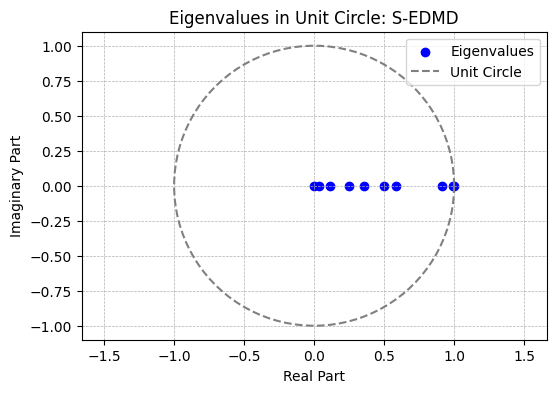

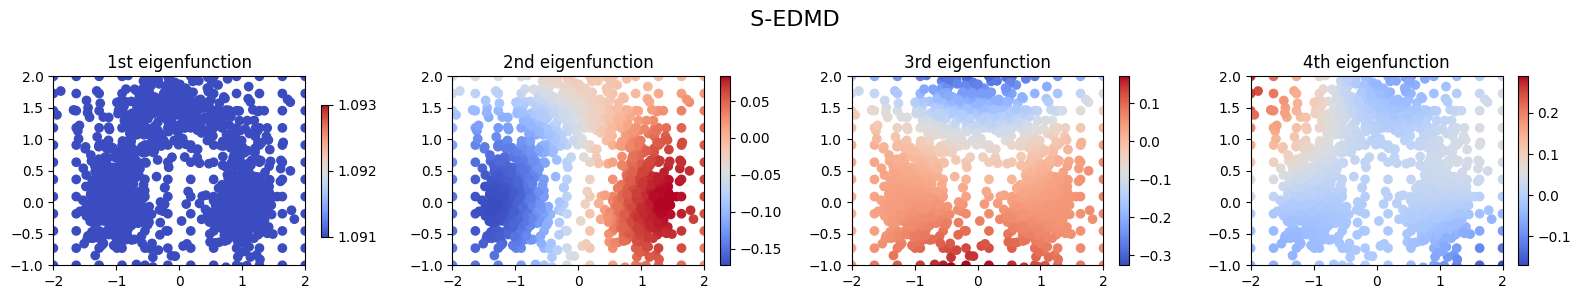

In [10]:
# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data

# Assuming evalues is a numpy array of complex numbers
print(evalues.shape)
print(evalues)

# Plot eigenvalues on unit circle
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: S-EDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])
fig.suptitle(' S-EDMD ', fontsize=16)
plt.tight_layout()
plt.show()


In [11]:
checkpoint_file_g= 'well2d_example_ckpt004_g.torch'

basis_function_g = KoopmanNNTorch(input_size= 2, layer_sizes=[10], n_psi_train=7).to(device)  # basis number would be 20


solver_g = KoopmanSolverTorch_g(dic=basis_function_g, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file_g, fnn_checkpoint_file= 'example_fnn001.torch', 
                            a_b_file= 'a_b_example_3ple_well.jbl', 
                        generator_batch_size= 2, fnn_batch_size= 32)

solver_g.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=16,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_gedmd
evalues = solver_g.eigenvalues.T
efuns = solver_g.eigenfunctions(X)
#kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver_g.get_Psi_X()
Psi_Y = solver_g.get_Psi_Y()


outputs = {
    'efuns': efuns,
    'evalues': evalues,
#    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
#    'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    }



Precomputed SDE coefficients loaded from: a_b_example_3ple_well.jbl
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4570.27iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Outer Epoch 1/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4614.37iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4755.56iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4706.05iteration/s]


Epoch: 1 	Training Loss: 5.725547 val loss: 12.034227
saving, val loss enhanced: 12.034227339954956 1000000000000000.0
Epoch: 2 	Training Loss: 5.721631 val loss: 12.028737
saving, val loss enhanced: 12.028736907322493 12.034227339954956
Epoch: 3 	Training Loss: 5.717816 val loss: 12.023201
saving, val loss enhanced: 12.02320104749836 12.028736907322493
Epoch: 4 	Training Loss: 5.714018 val loss: 12.017652
saving, val loss enhanced: 12.017651761031189 12.02320104749836
Epoch 1 time: 9.63 seconds
Outer Epoch 2/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4511.55iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4752.83iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4743.27iteration/s]


Epoch: 1 	Training Loss: 5.697431 val loss: 11.976073
saving, val loss enhanced: 11.976072567520253 12.017651761031189
Epoch: 2 	Training Loss: 5.693664 val loss: 11.970553
saving, val loss enhanced: 11.970552678598995 11.976072567520253
Epoch: 3 	Training Loss: 5.689903 val loss: 11.965039
saving, val loss enhanced: 11.965039091985263 11.970552678598995
Epoch: 4 	Training Loss: 5.686148 val loss: 11.959532
saving, val loss enhanced: 11.959531919946723 11.965039091985263
Epoch 2 time: 9.70 seconds
Outer Epoch 3/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4531.54iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4749.28iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4813.61iteration/s]


Epoch: 1 	Training Loss: 5.670112 val loss: 11.918735
saving, val loss enhanced: 11.918735009940255 11.959531919946723
Epoch: 2 	Training Loss: 5.666383 val loss: 11.913271
saving, val loss enhanced: 11.913270629276404 11.918735009940255
Epoch: 3 	Training Loss: 5.662659 val loss: 11.907815
saving, val loss enhanced: 11.907814663106983 11.913270629276404
Epoch: 4 	Training Loss: 5.658940 val loss: 11.902366
saving, val loss enhanced: 11.902365631830001 11.907814663106983
Epoch 3 time: 9.67 seconds
Outer Epoch 4/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4750.13iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4740.58iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4789.12iteration/s]


Epoch: 1 	Training Loss: 5.643059 val loss: 11.861965
saving, val loss enhanced: 11.861965489745335 11.902365631830001
Epoch: 2 	Training Loss: 5.639364 val loss: 11.856558
saving, val loss enhanced: 11.856558212895012 11.861965489745335
Epoch: 3 	Training Loss: 5.635674 val loss: 11.851159
saving, val loss enhanced: 11.851158601059817 11.856558212895012
Epoch: 4 	Training Loss: 5.631989 val loss: 11.845765
saving, val loss enhanced: 11.845764982264884 11.851158601059817
Epoch 4 time: 9.60 seconds
Outer Epoch 5/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4741.56iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4826.76iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4341.41iteration/s]


Epoch: 1 	Training Loss: 5.616251 val loss: 11.805755
saving, val loss enhanced: 11.8057550597719 11.845764982264884
Epoch: 2 	Training Loss: 5.612589 val loss: 11.800401
saving, val loss enhanced: 11.800401065710526 11.8057550597719
Epoch: 3 	Training Loss: 5.608932 val loss: 11.795054
saving, val loss enhanced: 11.795053928661563 11.800401065710526
Epoch: 4 	Training Loss: 5.605278 val loss: 11.789712
saving, val loss enhanced: 11.789711987536855 11.795053928661563
Epoch 5 time: 9.67 seconds
Outer Epoch 6/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4785.18iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4707.92iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4761.48iteration/s]


Epoch: 1 	Training Loss: 5.589675 val loss: 11.750069
saving, val loss enhanced: 11.750069354284971 11.789711987536855
Epoch: 2 	Training Loss: 5.586044 val loss: 11.744765
saving, val loss enhanced: 11.744765338834586 11.750069354284971
Epoch: 3 	Training Loss: 5.582418 val loss: 11.739468
saving, val loss enhanced: 11.739467608135781 11.744765338834586
Epoch: 4 	Training Loss: 5.578796 val loss: 11.734175
saving, val loss enhanced: 11.73417453114804 11.739467608135781
Epoch 6 time: 9.58 seconds
Outer Epoch 7/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4615.94iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4755.64iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4530.58iteration/s]


Epoch: 1 	Training Loss: 5.563322 val loss: 11.694881
saving, val loss enhanced: 11.694880912419626 11.73417453114804
Epoch: 2 	Training Loss: 5.559722 val loss: 11.689624
saving, val loss enhanced: 11.689624496671795 11.694880912419626
Epoch: 3 	Training Loss: 5.556127 val loss: 11.684374
saving, val loss enhanced: 11.684373973635358 11.689624496671795
Epoch: 4 	Training Loss: 5.552535 val loss: 11.679128
saving, val loss enhanced: 11.679127736387287 11.684373973635358
Epoch 7 time: 9.75 seconds
Outer Epoch 8/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4252.01iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4608.37iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4711.85iteration/s]


Epoch: 1 	Training Loss: 5.537186 val loss: 11.640170
saving, val loss enhanced: 11.640169940393742 11.679127736387287
Epoch: 2 	Training Loss: 5.533616 val loss: 11.634959
saving, val loss enhanced: 11.634959382492006 11.640169940393742
Epoch: 3 	Training Loss: 5.530050 val loss: 11.629754
saving, val loss enhanced: 11.629754436173057 11.634959382492006
Epoch: 4 	Training Loss: 5.526488 val loss: 11.624554
saving, val loss enhanced: 11.62455351343538 11.629754436173057
Epoch 8 time: 10.02 seconds
Outer Epoch 9/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4780.37iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4805.84iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4796.96iteration/s]


Epoch: 1 	Training Loss: 5.511263 val loss: 11.585922
saving, val loss enhanced: 11.585921682462825 11.62455351343538
Epoch: 2 	Training Loss: 5.507722 val loss: 11.580756
saving, val loss enhanced: 11.580755630758862 11.585921682462825
Epoch: 3 	Training Loss: 5.504186 val loss: 11.575595
saving, val loss enhanced: 11.57559497644209 11.580755630758862
Epoch: 4 	Training Loss: 5.500652 val loss: 11.570438
saving, val loss enhanced: 11.570438147892851 11.57559497644209
Epoch 9 time: 9.54 seconds
Outer Epoch 10/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4905.18iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4655.74iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4639.89iteration/s]


Epoch: 1 	Training Loss: 5.485549 val loss: 11.532124
saving, val loss enhanced: 11.532124468481937 11.570438147892851
Epoch: 2 	Training Loss: 5.482037 val loss: 11.527002
saving, val loss enhanced: 11.527001812411678 11.532124468481937
Epoch: 3 	Training Loss: 5.478529 val loss: 11.521884
saving, val loss enhanced: 11.521884381296088 11.527001812411678
Epoch: 4 	Training Loss: 5.475024 val loss: 11.516771
saving, val loss enhanced: 11.516770618926389 11.521884381296088
Epoch 10 time: 9.56 seconds
Outer Epoch 11/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4716.28iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4716.46iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4913.93iteration/s]


Epoch: 1 	Training Loss: 5.460041 val loss: 11.478769
saving, val loss enhanced: 11.478768564956912 11.516770618926389
Epoch: 2 	Training Loss: 5.456557 val loss: 11.473688
saving, val loss enhanced: 11.473688349688988 11.478768564956912
Epoch: 3 	Training Loss: 5.453077 val loss: 11.468613
saving, val loss enhanced: 11.468613214258207 11.473688349688988
Epoch: 4 	Training Loss: 5.449601 val loss: 11.463542
saving, val loss enhanced: 11.463541617618452 11.468613214258207
Epoch 11 time: 9.55 seconds
Outer Epoch 12/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4781.36iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4806.74iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4607.23iteration/s]


Epoch: 1 	Training Loss: 5.434737 val loss: 11.425846
saving, val loss enhanced: 11.425845517541427 11.463541617618452
Epoch: 2 	Training Loss: 5.431281 val loss: 11.420807
saving, val loss enhanced: 11.420806894216986 11.425845517541427
Epoch: 3 	Training Loss: 5.427828 val loss: 11.415773
saving, val loss enhanced: 11.415773224340137 11.420806894216986
Epoch: 4 	Training Loss: 5.424379 val loss: 11.410743
saving, val loss enhanced: 11.410742982065871 11.415773224340137
Epoch 12 time: 9.56 seconds
Outer Epoch 13/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4444.23iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4528.12iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4659.70iteration/s]


Epoch: 1 	Training Loss: 5.409634 val loss: 11.373348
saving, val loss enhanced: 11.37334776498597 11.410742982065871
Epoch: 2 	Training Loss: 5.406205 val loss: 11.368350
saving, val loss enhanced: 11.368349960522133 11.37334776498597
Epoch: 3 	Training Loss: 5.402779 val loss: 11.363357
saving, val loss enhanced: 11.363356996521002 11.368349960522133
Epoch: 4 	Training Loss: 5.399357 val loss: 11.358367
saving, val loss enhanced: 11.358367362463971 11.363356996521002
Epoch 13 time: 10.01 seconds
Outer Epoch 14/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4449.74iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4521.45iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4598.37iteration/s]


Epoch: 1 	Training Loss: 5.384730 val loss: 11.321268
saving, val loss enhanced: 11.321268398829721 11.358367362463971
Epoch: 2 	Training Loss: 5.381327 val loss: 11.316311
saving, val loss enhanced: 11.316310696777625 11.321268398829721
Epoch: 3 	Training Loss: 5.377929 val loss: 11.311358
saving, val loss enhanced: 11.31135773217143 11.316310696777625
Epoch: 4 	Training Loss: 5.374533 val loss: 11.306408
saving, val loss enhanced: 11.306408009945333 11.31135773217143
Epoch 14 time: 9.94 seconds
Outer Epoch 15/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4554.37iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4279.52iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4795.84iteration/s]


Epoch: 1 	Training Loss: 5.360022 val loss: 11.269601
saving, val loss enhanced: 11.26960101134739 11.306408009945333
Epoch: 2 	Training Loss: 5.356646 val loss: 11.264683
saving, val loss enhanced: 11.26468273924889 11.26960101134739
Epoch: 3 	Training Loss: 5.353274 val loss: 11.259769
saving, val loss enhanced: 11.259769109246678 11.26468273924889
Epoch: 4 	Training Loss: 5.349905 val loss: 11.254859
saving, val loss enhanced: 11.254858641821878 11.259769109246678
Epoch 15 time: 10.00 seconds
Outer Epoch 16/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4519.42iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4591.59iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4663.58iteration/s]


Epoch: 1 	Training Loss: 5.335509 val loss: 11.218340
saving, val loss enhanced: 11.218339590856989 11.254858641821878
Epoch: 2 	Training Loss: 5.332159 val loss: 11.213460
saving, val loss enhanced: 11.213460111581707 11.218339590856989
Epoch: 3 	Training Loss: 5.328813 val loss: 11.208585
saving, val loss enhanced: 11.208585185129797 11.213460111581707
Epoch: 4 	Training Loss: 5.325469 val loss: 11.203713
saving, val loss enhanced: 11.203713347581125 11.208585185129797
Epoch 16 time: 9.83 seconds
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4791.54iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0


(10,)
[1.41009273-0.4544559j  1.41009273+0.4544559j  1.2936932 +0.j
 1.        +0.j         0.98792949+0.j         0.91863513+0.j
 0.32663447-0.12921371j 0.32663447+0.12921371j 0.31207487+0.j
 0.20196953+0.j        ]


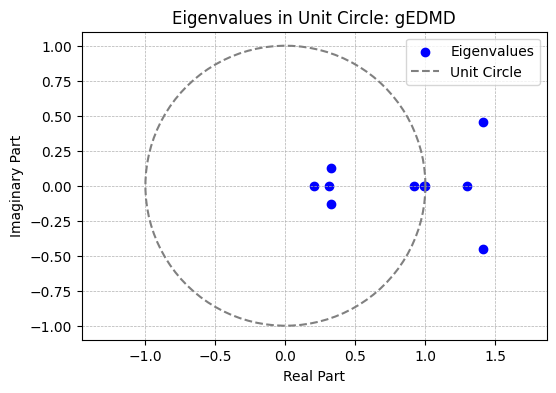

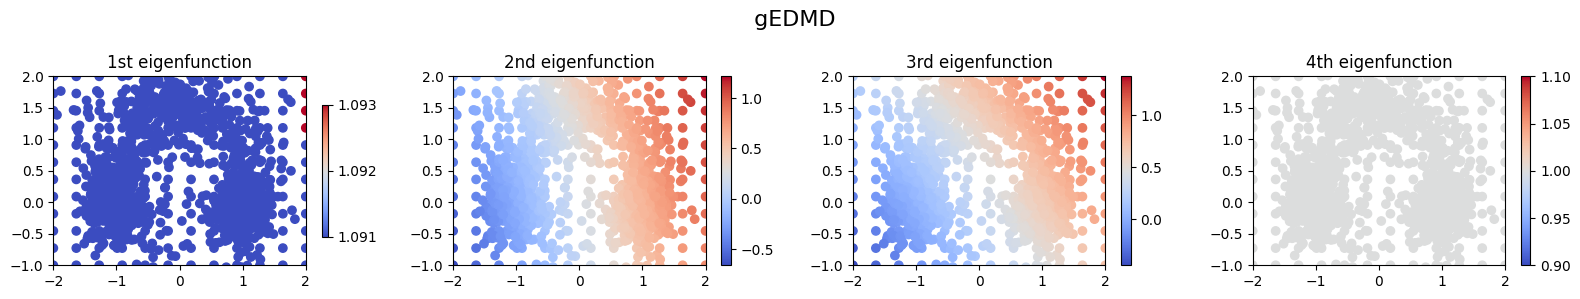

In [12]:
#computing eigenvalues of K from generator eigenvalues using exponetnt
#eigenfunctions are the same for the operator and the generator
evalues= np.exp(evalues)

# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data
# Assuming evalues is a numpy array of complex numbers

print(evalues.shape)
print(evalues)

# Plot eigenvalues on unit circle
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: gEDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])
fig.suptitle(' gEDMD ', fontsize=16)
plt.tight_layout()
plt.show()
